<a href="https://colab.research.google.com/github/Sujay2810/Projects/blob/main/Copy_of_notebook8b39c1f539.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-tumor-mri-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1608934%2F2645886%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240422%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240422T132025Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da61ef90487299831b54d89d6f180835662284057c1b62e4708b4a27ca06210ea4949043b504c2b256231f8da611b0f79991192f2376debdb3cfa656c37fd9cf7cddc9ec51f812799d076dbe6ad46402577ab42eb2f5e54a17084ae235d41021962e4e615ee91b73b269ab997cfbf9dc79a1a607df9596d862c6b6863b432b9717f265947a651749a2d139f47031e950e6aba414dc136f9bfda470b4545d1a9b65b513e63238e51c5f7e5c39c64c66a1a0d7969c501522161e46613a8ad9de6c83351c5f9b0462a7ecd5f64f7946f9cdb0b74a231907a3e4602e66b92aea1314dd20cb9cce00d9eb043b75aa8b66f021c7631b62b4eedf781fe424cc40476302c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 155791278 bytes downloaded
Downloaded and uncompressed: brain-tumor-mri-dataset
Data source import complete.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [ ]:
labels = ['glioma','notumor','meningioma','pituitary']

In [ ]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-mri-dataset','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-mri-dataset','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 300/300 [00:00<00:00, 468.96it/s]


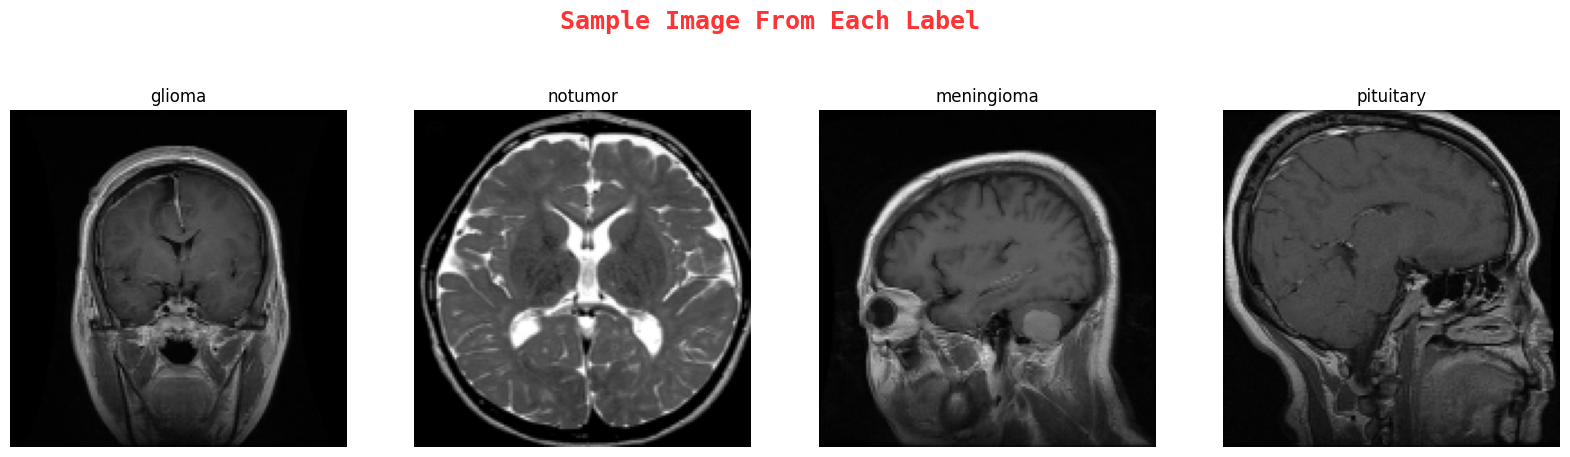

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color='red',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=42)

In [ ]:
X_train.shape

(7023, 150, 150, 3)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=42)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=1)


In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =30, verbose=1, batch_size=32,callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/30
178/178 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9833
Epoch 1: val_accuracy improved from -inf to 0.96361, saving model to effnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


178/178 [==============================] - 25s 138ms/step - loss: 0.0514 - accuracy: 0.9833 - val_loss: 0.1275 - val_accuracy: 0.9636 - lr: 0.0010
Epoch 2/30
178/178 [==============================] - ETA: 0s - loss: 0.0411 - accuracy: 0.9863
Epoch 2: val_accuracy did not improve from 0.96361
178/178 [==============================] - 24s 134ms/step - loss: 0.0411 - accuracy: 0.9863 - val_loss: 0.2544 - val_accuracy: 0.9320 - lr: 0.0010
Epoch 3/30
178/178 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9907
Epoch 3: val_accuracy improved from 0.96361 to 0.98892, saving model to effnet.h5
178/178 [==============================] - 24s 137ms/step - loss: 0.0312 - accuracy: 0.9907 - val_loss: 0.0341 - val_accuracy: 0.9889 - lr: 0.0010
Epoch 4/30
178/178 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9954
Epoch 4: val_accuracy did not improve from 0.98892
178/178 [==============================] - 24s 137ms/step - loss: 0.0182 - accuracy: 0.

In [ ]:
# Evaluating the model
loss= model.predict(X_test)
accuracy = model.predict(X_test)
print("Test Loss:",loss,":")
print("Test Accuracy:",accuracy,":")



22/22 [==============================] - 1s 28ms/step
Test Loss: [[2.0865628e-03 4.4067571e-04 9.8975986e-01 7.7128857e-03]
 [6.1476846e-09 1.0000000e+00 9.0374452e-10 8.1167972e-10]
 [2.8576482e-08 5.8082750e-10 3.9444384e-08 1.0000000e+00]
 ...
 [6.0854100e-09 5.4880398e-09 1.0000000e+00 2.4876488e-09]
 [3.3959626e-05 9.9954456e-01 3.2007374e-05 3.8949520e-04]
 [1.6406942e-06 9.9999762e-01 5.2804523e-07 2.1994803e-07]] :
Test Accuracy: [[2.0865628e-03 4.4067571e-04 9.8975986e-01 7.7128857e-03]
 [6.1476846e-09 1.0000000e+00 9.0374452e-10 8.1167972e-10]
 [2.8576482e-08 5.8082750e-10 3.9444384e-08 1.0000000e+00]
 ...
 [6.0854100e-09 5.4880398e-09 1.0000000e+00 2.4876488e-09]
 [3.3959626e-05 9.9954456e-01 3.2007374e-05 3.8949520e-04]
 [1.6406942e-06 9.9999762e-01 5.2804523e-07 2.1994803e-07]] :


Overall Loss: Approximately 0.00209
Overall Accuracy: Approximately 0.98976

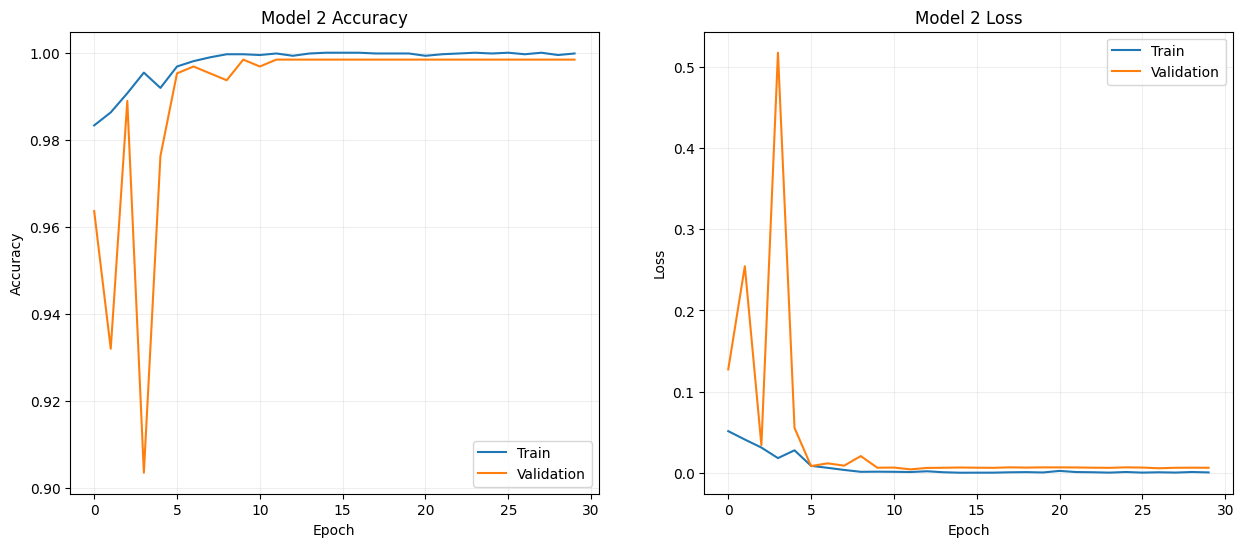

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()


In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

22/22 [==============================] - 1s 31ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       141
           1       1.00      1.00      1.00       208
           2       0.98      0.99      0.99       185
           3       0.99      0.99      0.99       169

    accuracy                           0.99       703
   macro avg       0.99      0.99      0.99       703
weighted avg       0.99      0.99      0.99       703



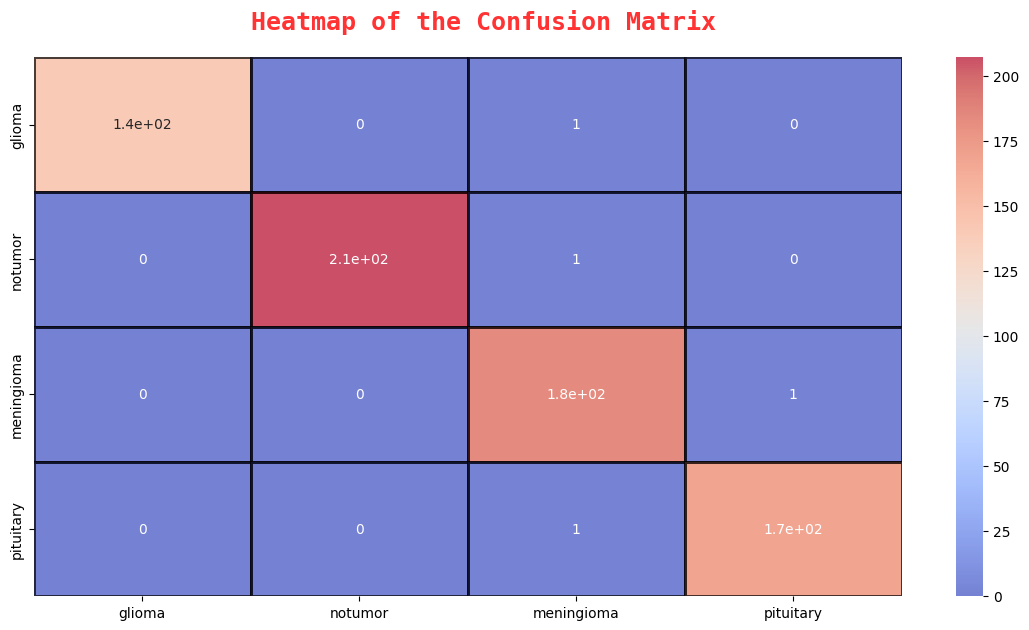

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
cmap_name = 'coolwarm'  # Choose an appropriate colormap name
sns.heatmap(confusion_matrix(y_test_new, pred), ax=ax, xticklabels=labels, yticklabels=labels,
            annot=True, cmap=cmap_name, alpha=0.7, linewidths=2, linecolor='black')
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color='red',y=0.92,x=0.28,alpha=0.8)

plt.show()